In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_autoenc import SideInformationAutoEncoder

from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config



from dsin.train_utils.visibilty_utils.logger_cb_utils import setup_file_logger
from dsin.train_utils.visibilty_utils.pbar_cb_utils import (AverageMetric,
                                            ParameterMetricCallback,
                                            ProgressBarAttibuteVisualizer,
                                            ParameterRunningAverageMetricCallback,
                                            BitEntropy
                                           )
from dsin.train_utils.save_utils import FileNameGenerator

In [5]:
bpp = 0.3
H_target = 2* bpp
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

# Load Critic Dataset

In [6]:
def get_crit_data(bs= 32, size=(336, 336)):
    path = "../src/dsin"
 
    kitti_stats = ([0.367, 0.385, 0.372], [0.288, 0.298, 0.301]) # mean, std

    data_image = (ImageList.from_csv(path=path, cols = 'name', csv_name = 'DISC_KITTI_TOT.txt')
                     .split_by_rand_pct(0.1, seed=42)
                     .label_from_df(cols='label')
                     .transform(None, size=size, resize_method=ResizeMethod.CROP)
                     .databunch(bs=bs)
                     .normalize(kitti_stats))
    #     data_image.c = 3
    data_image
    return data_image

In [7]:
# data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

data_crit = get_crit_data(bs = 4)

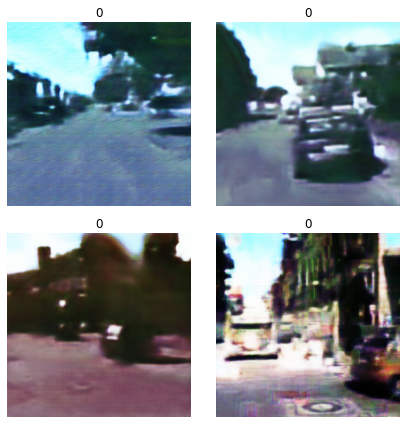

In [8]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)


In [9]:
class CapturingAdaptiveLoss(nn.Module):
    def __init__(self, crit): 
        super().__init__()
        self.crit = crit
        self.loss_critic_val = 1.0
        
    def forward(self, output, target:bool):
        targ = output.new_ones(*output.size()) if target else output.new_zeros(*output.size())
        self.loss_critic_val = self.crit(output, targ)
        return self.loss_critic_val
    
    
loss_critic = CapturingAdaptiveLoss(nn.BCEWithLogitsLoss())


# Create Critic

In [10]:
class SiCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = gan_critic()
    def forward(self,*vargs,**kwargs):
        return self.model(vargs[0])
        #if len(args) == 1: # assume single image input
        #if len(args) == 6 : # output from si_autoenv with loss variables then 0 position is x_reconstructed
            
            
            
        
    

In [11]:
wd = 1e-3

In [12]:

learn_critic = Learner(data_crit, SiCritic(), metrics=accuracy_thresh_expand, loss_func=AdaptiveLoss(nn.BCEWithLogitsLoss()), wd=wd)

In [13]:
learn_critic.fit_one_cycle(3, 1e-3)


epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.695366,0.673182,0.611619,01:37
1,0.291239,0.254292,0.883341,01:17
2,0.063435,0.036863,0.987381,01:17


KeyboardInterrupt: 

In [14]:
critic_model_fname = FileNameGenerator.create_fname(f'discriminator-bpp0p{bpp*100:.0f}')
critic_model_fname

'2020-09-03discriminator-bpp0p30'

In [16]:
learn_critic.save(critic_model_fname)
!aws s3 cp ~/tDSIN/src/dsin/models/{critic_model_fname}.pth  s3://dsin-us/models/


upload: ../src/dsin/models/2020-09-03discriminator-bpp0p30.pth to s3://dsin-us/models/2020-09-03discriminator-bpp0p30.pth


#  METRIC

In [17]:
           
class GenLogger(Callback):
    def __init__(self,learner, loss_man,attrs):
        self.loss_man = loss_man
        self.attrs = attrs
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        msg = ""
        
        for attr in self.attrs:
            msg += f"{attr}={getattr(self.loss_man,attr,None):.2f} "
        self.pbar.child.comment += msg

class ParameterRunningAverageMetricCallback2(ParameterRunningAverageMetricCallback) :
     def __init__(self,learn, loss_man,alpha=0.1,*args,**kwargs):
             super().__init__(loss_man,alpha)

# GAN

In [18]:
learn_critic=None
learn_gen = None
gc.collect()

10094

In [19]:
data_crit = get_crit_data(bs = 1)
learn_critic =(Learner(data_crit, SiCritic(), metrics=None, loss_func=loss_critic, wd=wd)
                  .load(critic_model_fname))# .load('20200818-critic-pre-gan'))


In [20]:

baseae_path = "../src/dsin/data"
pct= 1 #0.0005 #0.25
valid_image_list = SideinformationImageImageList.from_csv(
    path=baseae_path, csv_names=["KITTI_stereo_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=baseae_path, csv_names=["KITTI_stereo_train.txt"],pct=pct)

baseae_image_lists = ItemLists(
    path=baseae_path, train=train_image_list, valid=valid_image_list)

batchsize = 1

baseae_data = (baseae_image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 336), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))

In [22]:
gen_model_fname = '2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-7'

config.use_si_flag = SiNetChannelIn.WithSideInformation
config.si_loss_weight_alpha = 0.7
si_autoencoder = SideInformationAutoEncoder(base_line_auto_enc = BaseAutoEncoder())
learn_gen = Learner(data=baseae_data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(si_autoencoder,SiNetChannelIn.WithSideInformation,target_bit_cost= H_target, use_feat_loss=False), #True
                     ).load(gen_model_fname)




FileNotFoundError: [Errno 2] No such file or directory: '../src/dsin/data/models/2020-08-29MAE-l2reg-si-nofeat-bpp0p30-unfrzd-7.pth'

In [47]:
for param in learn_gen.model.ae.parameters():
    param.requires_grad = False

In [48]:

@dataclass
class MyAdaptiveGANSwitcher(LearnerCallback):
    "Switcher that goes back to generator/critic when the loss goes below `gen_thresh`/`crit_thresh`."
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.count, self.critic_thresh, self.gen_thresh = 0, 30, 120
        
    def on_batch_end(self, last_loss, **kwargs):
        "Switch the model if necessary."
        enough_gen = self.gan_trainer.gen_mode and self.count % self.gen_thresh == 0
        enough_critic =  not self.gan_trainer.gen_mode and self.count % self.critic_thresh == 0
        if enough_gen or enough_critic:
            self.count = 0
            self.gan_trainer.switch()
        self.count += 1

In [ ]:
class GAN_LR_Switcher(LearnerCallback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, learn:Learner):
        super().__init__(learn)
        

    def on_batch_begin(self, train, **kwargs):
        "Multiply the current lr if necessary."
        if self.learn.gan_trainer.gen_mode and train: self.learn.opt.lr = self.learn.gen_custom_lr
        if (not self.learn.gan_trainer.gen_mode) and train: self.learn.opt.lr = self.learn.critic_custom_lr

In [49]:
switcher = MyAdaptiveGANSwitcher #partial(AdaptiveGANSwitcher, critic_thresh=0.65)
gan_learn = GANLearner.from_learners(learn_gen, learn_critic, weights_gen=(200.,1.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
gan_learn.callback_fns.append(partial(ParameterRunningAverageMetricCallback2,loss_man=learn_gen.loss_func, alpha =0.1))
gan_learn.callback_fns.append(partial(GenLogger, loss_man=learn_critic.loss_func,attrs=['loss_critic_val']))
gan_learn.callback_fns.append(GAN_LR_Switcher)
# gan_learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))


In [50]:
gan_learn.gen_custom_lr = 1e-5
gan_learn.critic_custom_lr = 4e-4
gan_learn.fit(6,gan_learn.gen_custom_lr)

In [ ]:
mt =torch.load('vargs1').detach()[0,...]
show_image(Image(mt),figsize=(10,10))


In [18]:
learn.save('gan-1c')


NameError: name 'learn' is not defined

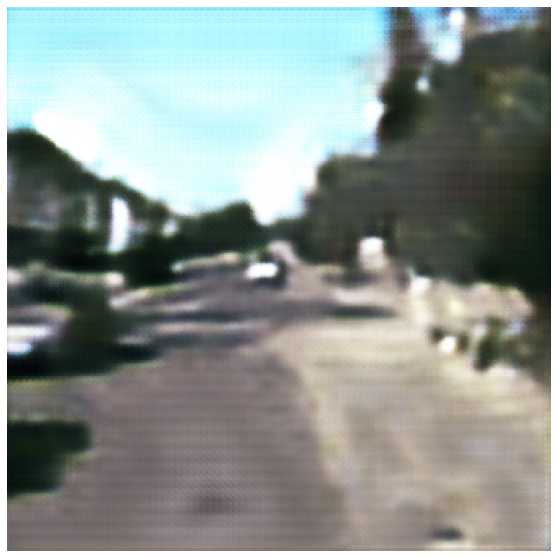

In [57]:
mt = learn_gen.model.my_tuple[3].detach()[0,...] 

show_image(Image(mt),figsize=(10,10))

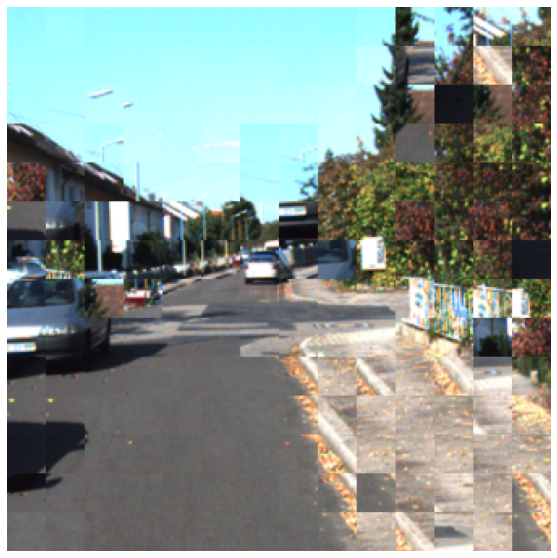

In [60]:
mt = learn_gen.model.my_tuple[0].detach()[0,...] / 255

show_image(Image(mt),figsize=(10,10))


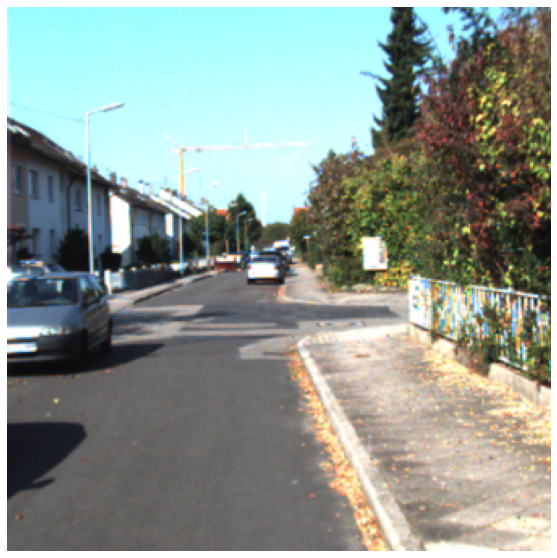

In [62]:
mt = learn_gen.model.my_tuple[-3].squeeze_().detach()

show_image(Image(mt),figsize=(10,10))
